# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

## Подготовка данных

In [1]:
!pip install category_encoders
!pip install lightgbm

     |████████████████████████████████| 81 kB 8.1 kB/s eta 0:00:01


In [2]:
import time

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

from sklearn.experimental import enable_halving_search_cv

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingGridSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RND_SEED = 1234

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv', parse_dates=[0,12,15])
except:
    data = pd.read_csv('/Users/evgeniu/Desktop/Рабочий стол — MacBook Pro — Евгений/Education/Practicum /AutoPrice/autos.csv', parse_dates=[0,12,15])

In [4]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


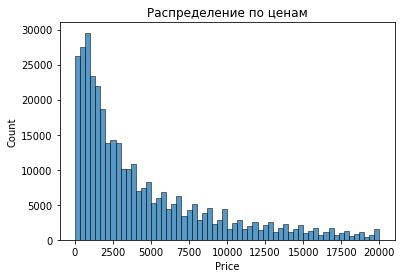

In [7]:
sns.histplot(data['Price'], bins=60).set(title='Распределение по ценам');

Распределение данных нормальное, кроме цен за 0€, а так же небольшой хвост в верхнем пределе. Продавцы любят круглые ценники, по-этому график имеет такой "зубастый" вид.

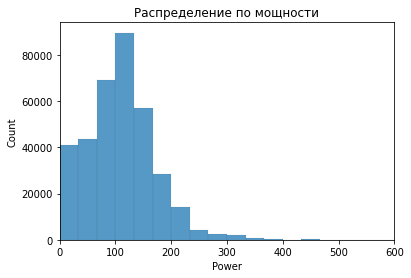

In [8]:
fig, ax = plt.subplots()
sns.histplot(data['Power'], bins=600, ax=ax).set(title='Распределение по мощности');
ax.set_xlim(0, 600)
plt.show()

Здесь данные имеют сильный разброс связанный со спецификой зависимости мощностей авто от двигателя. Диапазон 50 - 100 л.с - это малолитражки и старые автомобилис атмосферными моторами. 100-180 это современные 1.5 - 1.8л моторы из которых самый популярный 1.6 на 110-130л.с. 2л моторы используют до 250л.с в гражданских версиях что указывает на поведение графика. Все что мощнее - это редкие и дорогие моторы. Многие производители продают авто с задушеными моторами на низкую налоговую категорию (149. 199, 249 л.с.) что объясняет некоторые всплески на графике. 0л.с - это аномалия, авто с мощностью выше 550 стоит просмотреть отдельно в предобработке.

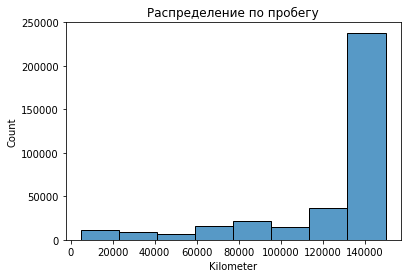

In [9]:
sns.histplot(data['Kilometer'],bins=8).set(title='Распределение по пробегу');

Тут большая проблема в указании пробега. Такие значения могут сильно мешать обучению. 70% данных имеют предельное значение пробега в 150000. 

In [10]:
data['DateCreated'].describe()

/tmp/ipykernel_48/572264387.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['DateCreated'].describe()


count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [11]:
sum(data['DateCreated'].dt.year < 2016)

26

Разбег дат по дате публикации не превышает пяти месяцев кроме 26 объявлений. Это не критично. 
Исходя из данных этого столбца можно не учитывать фактор времени размещения в этой работе, так как временной интервал узкий для авторынка. Так-же этот столбец не будет применяться в модели машинного обучения.

### Вывод

* Всего записей 354369. 16 столбцов. 
* Имеются пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired
* В работе нет необходимости использовать столбцы с датами так-как рассматривается узкий временной диапазон.
* NumberOfPictures - пустой столбец, возможно это ошибка выгрузки.
* В столбце Kilometer имеется проблема: 3, 4 квантиль и максимальное значения = 150000. Либо выборка была искуственно ограничена, либо проблема в способе получения или хранения данных.
* Price, Power имеют аномальные максимальные и нулевые значения.
* RegistrationMonth имеет диапазон из 13 значений 0-12 - ошибка интерпретации.
* RegistrationYear Имеет аномальные значения
* Имена столбцов в CamelCase. 

## Предобратока данных.

Исправим названия колонок

In [12]:
import re
def to_camel(s):
    s = re.sub( r"([A-Z])", r" \1", s).split()
    for i in range(len(s[:-1])): s[i] = s[i] + '_'
    return ''.join(s).lower()

In [13]:
data.columns = map(to_camel, data.columns)

столбцы date_crawled, date_created, number_of_pictures, postal_code, last_seen не несут полезных данных для модели. Удалим:

In [14]:
data = data.drop(['date_crawled','date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

In [15]:
data = data[data['price'] > 0]

In [16]:
data['power'][data['power'] > 600].value_counts().head(5)

1800    8
1598    7
1000    7
1400    7
1001    6
Name: power, dtype: int64

В выборке нет крупной группы, указывающей на какой-либо тип моторов. Мощность > 600 можно убрать.

In [17]:
data = data[(data['power'] < 600)]

In [18]:
data['power'][data['power'] == 0].count()

36360

Объявлений с мощностью =0 много. лучше попробовать восстановить данные.

In [19]:
data['power'][data['power'] == 0] = np.nan

In [20]:
data = data[(data['registration_year'] > 1950) & (data['registration_year'] <= 2016)]

In [21]:
data.shape[0]

329285

В ходе чистки аномалий удалено ≈10% данных.

In [22]:
data.isna().sum()

price                     0
vehicle_type          19869
registration_year         0
gearbox               15530
power                 32777
model                 15539
kilometer                 0
registration_month        0
fuel_type             24064
brand                     0
repaired              59676
dtype: int64

В записях имеются данные с пропусками. Пропуски в указании модели авто критичны, качественно идентифицировать модель по прочим параметрам не получится. С целью сохранения данных  неизвестные модели авто можно объявить именем 'unnamed'

In [23]:
data.loc[:,['model', 'fuel_type', 'gearbox', 'vehicle_type', 'repaired']] = \
data.loc[:,['model', 'fuel_type', 'gearbox', 'vehicle_type', 'repaired']].fillna('unnamed')

Оставшиеся пропуски заполним позже методом близжайших соседей чуть позже

In [24]:
data.duplicated().sum()

25501

In [25]:
data = data.drop_duplicates().reset_index(drop=True)

Дубликаты найдены и удалены

In [26]:
#Делим данные на выборки. Для обучения будет применена кросс-валидация, по-этому валидационную выборку не выделяем
data_train, data_test = train_test_split(data, test_size=.25, random_state=RND_SEED)

In [27]:
#Кодируем признаки
oe = OrdinalEncoder()
data_train.loc[:, ['vehicle_type', 'model', 'fuel_type', 'brand', 'repaired', 'gearbox']] = \
oe.fit_transform(data_train.loc[:, ['vehicle_type', 'model', 'fuel_type', 'brand', 'repaired', 'gearbox']])
data_test.loc[:, ['vehicle_type', 'model', 'fuel_type', 'brand', 'repaired', 'gearbox']] = \
oe.transform(data_test.loc[:, ['vehicle_type', 'model', 'fuel_type', 'brand', 'repaired', 'gearbox']])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [28]:
data_train.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
145003,450,8.0,1994,1.0,NaN,228.0,150000,11,2.0,24.0,1.0
70365,4950,7.0,2016,1.0,115.0,80.0,125000,0,6.0,21.0,0.0
270034,4800,5.0,2009,1.0,80.0,109.0,20000,6,6.0,10.0,0.0
48725,4100,0.0,2005,0.0,129.0,236.0,125000,1,6.0,36.0,0.0
23010,2499,0.0,2001,1.0,88.0,224.0,150000,1,2.0,38.0,0.0


In [29]:
#Заполняем числовые пропуски методом близжайших соседей
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit(data_train)

data_train_filled = pd.DataFrame(imputer.transform(data_train), 
                                 index=data_train.index, 
                                 columns=data_train.columns)
data_test_filled = pd.DataFrame(imputer.transform(data_test), 
                                 index=data_test.index, 
                                 columns=data_test.columns)

In [30]:
pd.DataFrame([data_test_filled.isna().sum(), data_train_filled.isna().sum()], index=['test', 'train'])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
test,0,0,0,0,0,0,0,0,0,0,0
train,0,0,0,0,0,0,0,0,0,0,0


Пропуски заполнены

In [33]:
Xtest, Xtrain, ytest, ytrain = data_test_filled.drop(columns='price', axis=1),\
    data_train_filled.drop(columns='price', axis=1),\
    data_test_filled['price'],\
    data_train_filled['price']

In [34]:
scaler = StandardScaler()
#scaler.set_output(transform='pandas')
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain),
                      index=Xtrain.index,
                      columns=Xtrain.columns)
Xtest = pd.DataFrame(scaler.transform(Xtest),
                      index=Xtest.index,
                      columns=Xtest.columns)

Пропуски заполнены, аномальные данные удалены, фичи отмасштабированы, признаки кодированы. Можно переходить к обучению

## Обучение моделей

В качестве метрики используем RMSE опишем отдельную функцию
Для оценки времени и фиксации результата напишем и применим методы benchmark и test_model. 

Для обучения применим следующие модели:
* Дерево решений
* Случайный лес
* LightGBM



In [35]:
def rmse(target,predictions):
    mse = mean_squared_error(target, predictions)
    return mse ** 0.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [36]:
stats = dict()

def model_test(name, model, features_test=Xtest, target_test=ytest, features_train=Xtrain, target_train=ytrain):
    #учим на лучших параметрах
    solver = model.estimator
    solver.set_params(**model.best_params_, random_state=RND_SEED)
    start = time.time()
    solver.fit(Xtrain,ytrain)
    fit = time.time()

    #Предсказываем 
    predicted_test = solver.predict(features_test)
    predict = time.time()

    rmse_test = rmse(target_test, predicted_test)
    rmse_train = rmse(target_train, solver.predict(features_train))

    #Заполняем результат
    stats[name] = {
        'name': name,
        'fit_time': fit-start,
        'predict_time': predict-fit,
        'rmse_test':rmse_test,
        'rmse_train':rmse_train
    }

In [37]:
def benchmark(func, notification=True):
    def wrapper():
        start = time.time()
        model_test(*func())
        end = time.time()
        if notification:
            print('Время выполнения: {} секунд.'.format(end-start))
    return wrapper

In [38]:
@benchmark
def decision_tree():
    decision_tree_model = DecisionTreeRegressor(random_state=RND_SEED)
    decision_parameters = {
                "max_depth": range(1, 11),
                "min_samples_leaf": range(1, 11)
    }

    decision_grid =  RandomizedSearchCV(estimator=decision_tree_model,
                                        param_distributions=decision_parameters, cv=5,
                                        scoring=rmse_scorer, n_iter = 20, n_jobs=-1)
    decision_grid.fit(Xtrain,ytrain)
    return 'Дерево решений', decision_grid

In [39]:
decision_tree()

Время выполнения: 23.445889234542847 секунд.


In [41]:
FAST_MODE=True #Для ускорения работы в jupyterhub выделил команду с предварительно отобранными оптимальными параметрами
@benchmark
def random_forest():
    random_forest_model = RandomForestRegressor(random_state=RND_SEED)
    if FAST_MODE: 
        params = {
            'max_depth': [15],
            'n_estimators': [600]
        }
    else:
        params = {
            'max_depth': range(13, 17, 2),
            'n_estimators':range(400, 601, 100)
        }
    forest_rs = HalvingGridSearchCV(estimator=random_forest_model,
                                    param_grid=params, scoring=rmse_scorer,
                                    factor=5, cv=5, n_jobs=-1, verbose=0)
    forest_rs.fit(Xtrain, ytrain)
    return 'Случайный лес', forest_rs

In [42]:
random_forest()

Время выполнения: 1838.7721064090729 секунд.


In [43]:
@benchmark
def lgb():
    if FAST_MODE:
        lgb_params = {
        'objective': ['regression'],
        'boosting_type' : ['gbdt'],
        'max_depth': [30],
        'num_leaves': [400],
        }
    else:
        lgb_params = {
            'objective': ['regression','regression_l1'],
            'boosting_type' : ['dart','gbdt'],
            'max_depth': [15,30,50],
            'num_leaves': range(100,401,100),
        }
    lgb_reg = LGBMRegressor(random_state=RND_SEED)
    lgb_gs = GridSearchCV(lgb_reg, lgb_params, scoring=rmse_scorer, n_jobs=-1, verbose=2)
    lgb_gs.fit(Xtrain, ytrain)
    return 'LightGBM', lgb_gs

In [44]:
lgb()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END boosting_type=gbdt, max_depth=30, num_leaves=400, objective=regression; total time=27.6min
[CV] END boosting_type=gbdt, max_depth=30, num_leaves=400, objective=regression; total time=  58.1s
[CV] END boosting_type=gbdt, max_depth=30, num_leaves=400, objective=regression; total time=  22.4s
[CV] END boosting_type=gbdt, max_depth=30, num_leaves=400, objective=regression; total time=  20.6s
[CV] END boosting_type=gbdt, max_depth=30, num_leaves=400, objective=regression; total time=  22.4s
Время выполнения: 1827.6032528877258 секунд.


## Анализ моделей

В процессе обучения были подготовлены три модели. В качестве результата выделены 4 параметра: 
* время обучения на оптимальных параметрах;
* время предсказания;
* качество предсказания RMSE тренировочного набора данных;
* качество предсказания RMSE тестового набора данных.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Выберем модель, которая наилучшим образом соответсвтует требованиям.

In [45]:
stats_df = pd.DataFrame.from_dict(data=stats, orient='index').reset_index(drop=True)
stats_df

,name,fit_time,predict_time,rmse_test,rmse_train
0,Дерево решений,0.477862,0.008829,1965.682257,1902.504100
1,Случайный лес,309.966240,8.911443,1646.220980,1267.506605
2,LightGBM,22.580274,1.012633,1554.359215,1334.651319


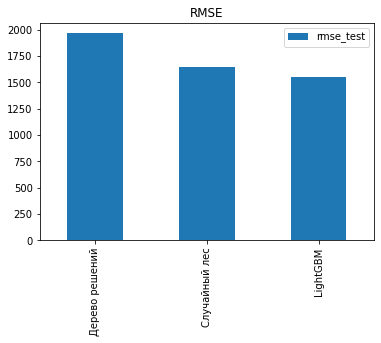

In [60]:
stats_df.plot(x='name', y='rmse_test', kind='bar', title = 'RMSE', xlabel='');

Все модели попадают по требование RMSE < 2500. Лучшая оценка у LightGBM модели.

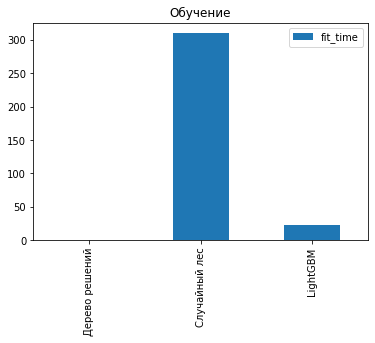

In [65]:
stats_df.plot(x='name', y='fit_time', kind='bar', title = 'Обучение', xlabel='');

Дерево решений обучается за 0.47 секунды. LightGBM требуется 22.5 секунды. Решающий лес обучился за 5 минут. Возможно это связано со сложностью модели или малыми выделяемыми ресурсами сервером.

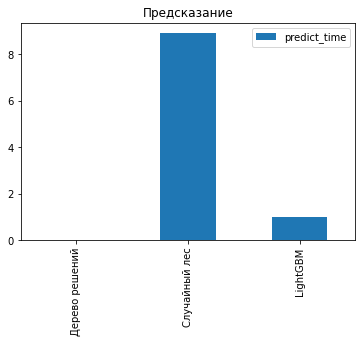

In [67]:
stats_df.plot(x='name', y='predict_time', kind='bar', title = 'Предсказание', xlabel='');

Модели предсказания имеют похожее распределение: Дерево решает задачу за 9мс. LightGBM справляется за 1сек.

# Вывод

Из рассмотренных моделей самой точной оказалась LightGBM. Так-же у неё высокая скорость предсказания и обучения. Быстрее работает решающее дерево, но качество предсказаний у него хуже. Цели проектной работы достигнуты. Модели соответствуют критериям заказчика и их можно применять для решения бизнес задач.